# Web Scraping with Python #

This notebook illustrates how to scrape a website in Python through a very simple example, using the ```scrapy``` package. In particular, we scrape the https://kworb.net/spotify/country/it_daily.html website, which reports the daily top 200 Spotify chart for Italy. One may replace the "it" in the URL with another country code to scrape the corresponding chart. 

We will extract from such a website songs, artists and streaming counts and store the resulting data into a Pandas dataframe for further analysis. 

In [1]:
# Importing libraries
from calendar import c
from urllib import request
from scrapy import Selector
from datetime import datetime

import matplotlib.pyplot as plt
import requests
import re
import pandas as pd

# Setting customized displaying options for Pandas DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

# Making a GET request
url = 'https://kworb.net/spotify/country/it_daily.html'
html = requests.get(url).content

# Creating the "Selector" object 

sel = Selector(text=html)

When scraping a single website page, the first action we need to perform is to "extract" the content of the website (the HTML code) and pass it to a **Selector**. Roughly speaking, a Selector is an object that *select* the entire HTML document. We can then use the ```xpath```call within a Selector to create new Selectors of specific pieces of the HTML code, namely those that "store" the information we are interested in. Remind that the XPath notation is not the only notation we can use to refer to specific sections of the HTML document. Alternatively, we can use *CSS locators* (or a mix of both). When calling ```.xpath```on a Selector object, it returns a *SelectorList*, i.e. a list of Selector objects. To get access to the actual data inside the Selector object we need an additional ```
extract()```method. 

The first piece of information we want to retrieve is the chart date. Looking at the website page, we note that the date appears on the main title. Let extract the title string with the ```extract_first()```method (which returns just the first element):

In [2]:
#Getting reference date
title = sel.xpath('//div[@class="subcontainer"]/span[@class="pagetitle"]/text()').extract_first()
print(title)

date = re.findall(r"\d{4}/\d{2}/\d{2}", title)
print(date)

Spotify Daily Chart - Italy - 2022/08/19 | 
['2022/08/19']


To retrieve each chart element, we have to investigate a bit the structure of the HTML code and understand where each information (such as artist name, song name and streaming count) is put. Once we have identified the path structure for each piece of information, we can write it down in the XPath notation and pass it to the ```.xpath```call as an argument. Take a look at this website (https://www.w3schools.com/xml/xpath_syntax.asp) to review the basics of the XPath notation. 

In [3]:
# Getting the list of songs, artists and corresponding streams

# Defining the corresponding XPaths:
artist_xpath_text = '//table[@class="sortable"]/tbody/tr/td[@class="text mp"]/div/a[1]/text()'
songs_xpath_text = '//table[@class="sortable"]/tbody/tr/td[@class="text mp"]/div/a[2]/text()'
streams_xpath_text = '//table[@class="sortable"]/tbody/tr/td[7]/text()'

artist_list = sel.xpath(artist_xpath_text).extract()
songs_list = sel.xpath(songs_xpath_text).extract()
streams_list_str = sel.xpath(streams_xpath_text).extract()

# Converting streams for strings to interger values:
streams_list = [ int(x.replace(",", "")) for x in streams_list_str]

## Creating a Pandas dataframe for analysis

We are now ready to store the extracted information into a Pandas dataframe to do some data analysis. Let add also an additional column storing the corresponding chart date. 

In [4]:
# Creating a date column
date_list = [datetime.strptime(date[0], "%Y/%m/%d") for i in range(len(songs_list))]

# Zipping columns and defining a DataFrame
chart_cols = list(zip(date_list, songs_list,artist_list,streams_list))
chart_df = pd.DataFrame(chart_cols, columns=['Date','Song', 'Artist', 'Streams'])

chart_df

,Date,Song,Artist,Streams
0,2022-08-19,s!r!,thasup,408512
1,2022-08-19,Capri Sun,Capo Plaza,359738
2,2022-08-19,Giovani Wannabe,Pinguini Tattici Nucleari,343267
3,2022-08-19,Hace Calor - Remix,Kaleb Di Masi,311964
4,2022-08-19,Extasi,Fred De Palma,297351
5,2022-08-19,LA DOLCE VITA,Fedez,289708
6,2022-08-19,Shakerando,Rhove,273906
7,2022-08-19,Caramello,Rocco Hunt,271225
8,2022-08-19,Tropicana,Boomdabash,269253
9,2022-08-19,USCITO DI GALERA,Lazza,267205


### Song and Artist charts ###

Let filter the top 200 daily Spotify chart to show just the first 50 positions and make a simple bar visual with the Matplotlib library:

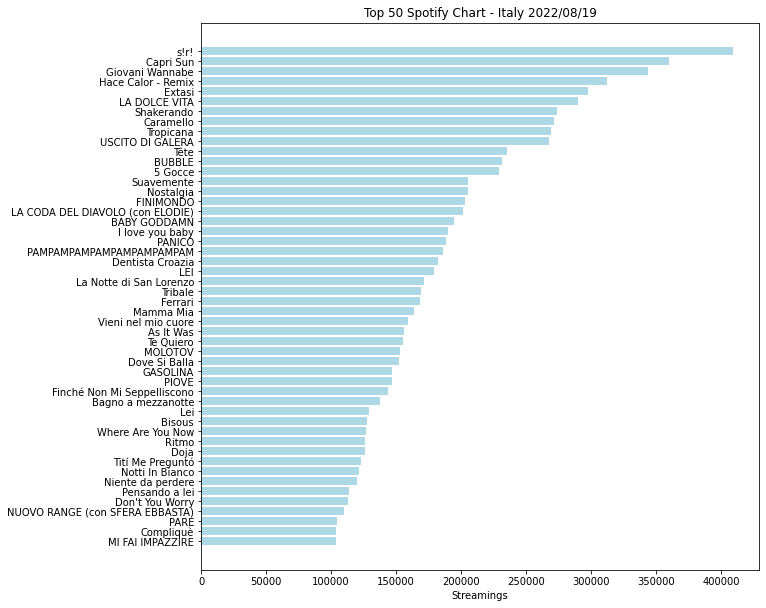

In [5]:
# Filtering just the top 20:
top50 = chart_df.sort_values('Streams', ascending=False).head(50)

fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111)
spacing = 0.5
fig.subplots_adjust(bottom=spacing)
plt.barh(y=top50["Song"], width=top50["Streams"], color="lightblue")
ax.invert_yaxis()
ax.set_xlabel('Streamings')
ax.set_title(f"Top 50 Spotify Chart - Italy {date[0]}")
plt.show()

Let aggregate the daily streamings by artist to display the top 50 artists by streaming plays. Lucky those who have more than one song in the top200 daily Chart!

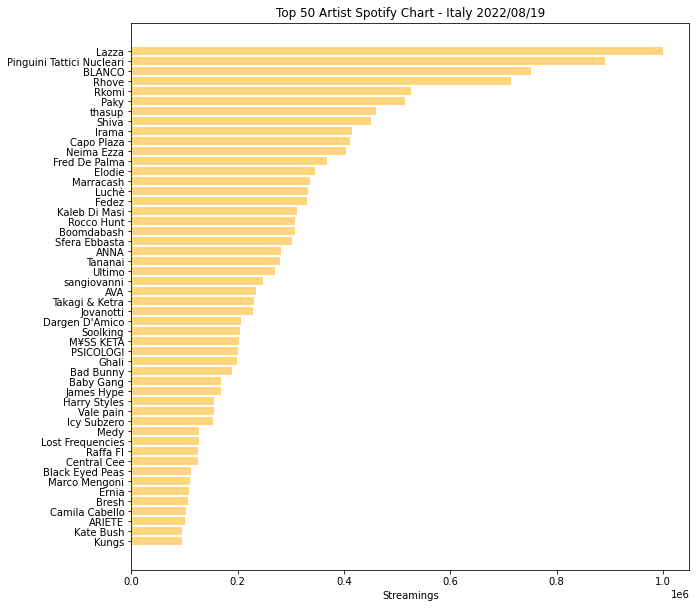

In [6]:
# Charts by artist
total_by_artist = chart_df.groupby("Artist", as_index=False).agg({'Streams':'sum'})
top50_artist = total_by_artist.sort_values("Streams", ascending=False).head(50)

fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111)
spacing = 0.5
fig.subplots_adjust(bottom=spacing)
plt.barh(y=top50_artist["Artist"], width=top50_artist["Streams"], color="#FFD580")
ax.invert_yaxis()
ax.set_xlabel('Streamings')
ax.set_title(f"Top 50 Artist Spotify Chart - Italy {date[0]}")
plt.show()